In [6]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

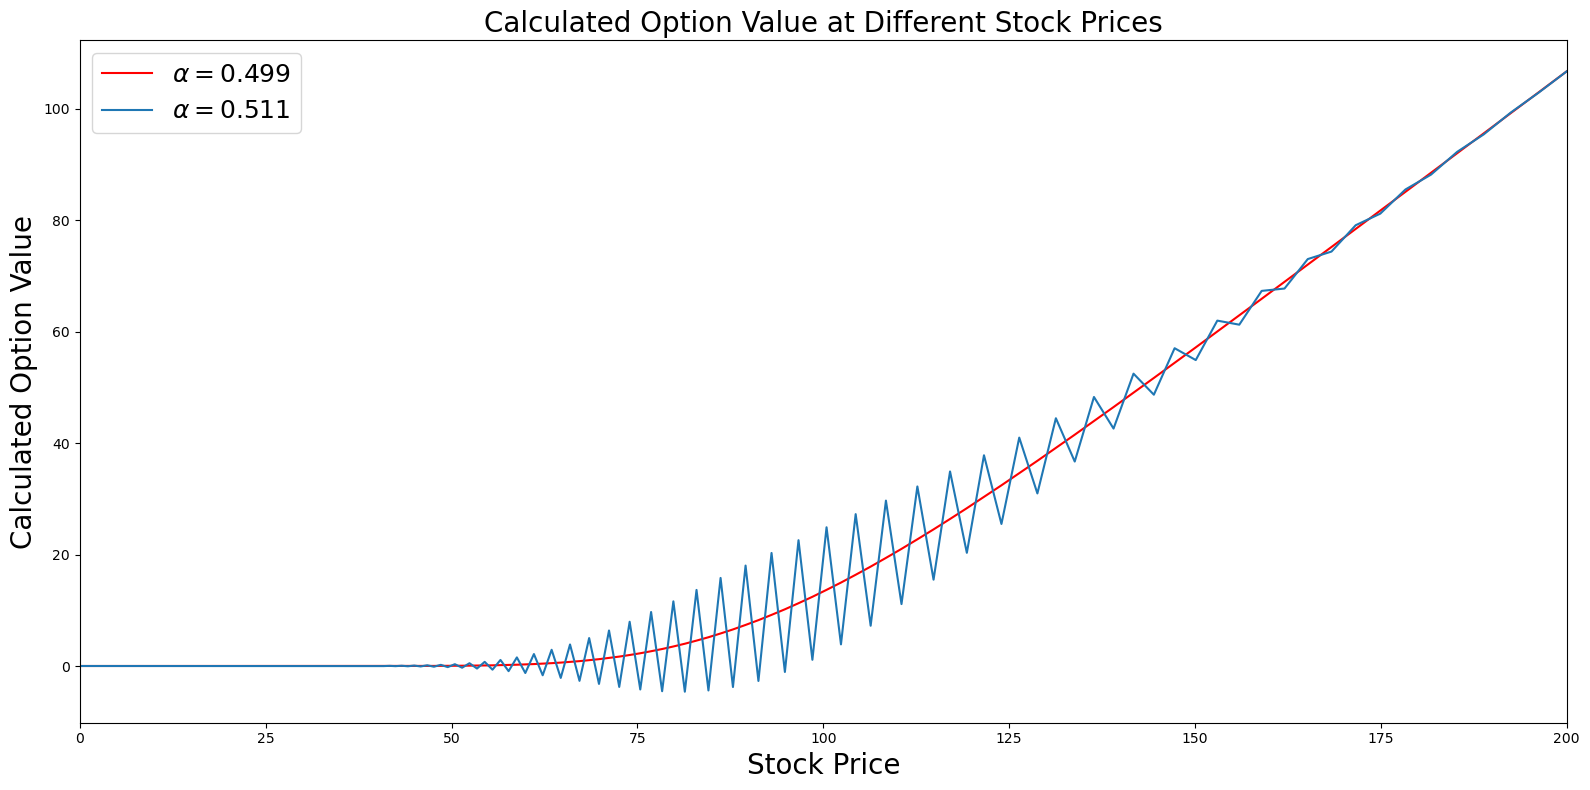

In [117]:
import numpy as np
from matplotlib.pyplot import subplots

# params and grids
K, r, sigma, T = 100.0, 0.07, 0.25, 1.0
q = 2*r/(sigma**2)
A = (1-q)/2
B = -((1-q)**2)/4 - q
Smin, Smax, Nx = 1e-6, 200.0, 1000
x = np.linspace(np.log(Smin/K), np.log(Smax/K), Nx); dx = x[1]-x[0]
tau_max = 0.5*sigma**2*T
u0 = np.exp(-A*x)*np.maximum(np.exp(x)-1.0, 0.0)      # payoff in heat variables
S  = K*np.exp(x)

fig, ax = subplots(figsize=(16, 8))

# alpha 1/2
alpha_target = 0.5
u = u0.copy(); tau = 0.0
dtau = alpha_target*dx*dx; M = max(1, int(np.ceil(tau_max/dtau))); dtau = tau_max/M
alpha = dtau/(dx*dx)

for _ in range(M):
    u_new = u.copy()
    u_new[1:-1] = u[1:-1] + alpha*(u[2:] - 2*u[1:-1] + u[:-2])
    u_new[0]  = 0.0
    u_new[-1] = np.exp((1-A)*x[-1]-B*tau) - np.exp(-(2*r/(sigma**2))*tau - A*x[-1]-B*tau)  # large-S
    u = u_new; tau += dtau
    if not np.isfinite(u).all() or np.max(np.abs(u))>1e6: 
        break
        
V = K*np.exp(A*x + B*tau)*u
ax.plot(np.concatenate(([0.0], S)), np.concatenate(([0.0], V)), label=rf'$\alpha={alpha:.3f}$', c = 'r')

# bad alpha blow up above 1/2
alpha_target = 0.513
u = u0.copy(); tau = 0.0
dtau = alpha_target*dx*dx; M = max(1, int(np.ceil(tau_max/dtau))); dtau = tau_max/M
alpha = dtau/(dx*dx)

for _ in range(M):
    u_new = u.copy()
    u_new[1:-1] = u[1:-1] + alpha*(u[2:] - 2*u[1:-1] + u[:-2])
    u_new[0]  = 0.0
    u_new[-1] = np.exp((1-A)*x[-1]-B*tau) - np.exp(-(2*r/(sigma**2))*tau - A*x[-1]-B*tau)
    u = u_new; tau += dtau
    if not np.isfinite(u).all() or np.max(np.abs(u))>1e6: 
        break
        
V = K*np.exp(A*x + B*tau)*u
ax.plot(np.concatenate(([0.0], S)), np.concatenate(([0.0], V)), label=rf'$\alpha={alpha:.3f}$')

# plottin
ax.set_xlim(0, 200)
ax.set_xlabel('Stock Price', fontsize=20)
ax.set_ylabel(r'Calculated Option Value', fontsize=20)
ax.set_title('Calculated Option Value at Different Stock Prices', fontsize=20)
ax.legend(fontsize=18)
fig.tight_layout()
fig.savefig('explicitstability.png')

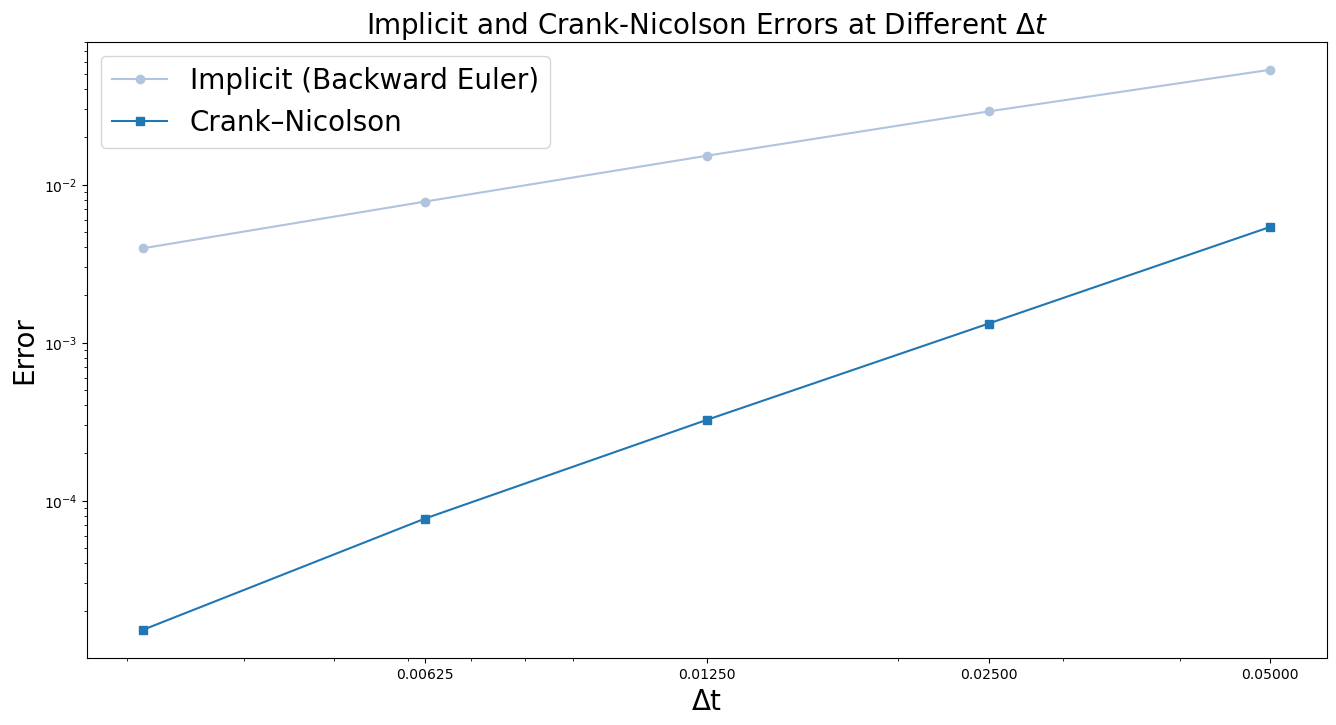

In [173]:
alpha = 1.0
L = 1.0
Nx = 200
dx = L / Nx
x = np.linspace(0, L, Nx + 1)

T = 0.1
u0 = np.sin(np.pi * x)

def exact_solution(x, t):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

dts = [0.05, 0.025, 0.0125, 0.00625, 0.003125]
errors_imp = []
errors_cn = []

for dt in dts:
    r = alpha * dt / dx**2
    u_imp = u0.copy()
    u_cn = u0.copy()
    
    a_imp = -r * np.ones(Nx - 1)
    b_imp = (1 + 2*r) * np.ones(Nx - 1)
    c_imp = -r * np.ones(Nx - 1)

    a_cn = -(r/2) * np.ones(Nx - 1)
    b_cn = (1 + r) * np.ones(Nx - 1)
    c_cn = -(r/2) * np.ones(Nx - 1)

    n_steps = int(T / dt)

    for _ in range(n_steps):
        # IMPLICIT
        rhs_imp = u_imp[1:-1].copy()
        # forward sweep
        cp = np.zeros(Nx - 2)
        dp = np.zeros(Nx - 1)
        cp[0] = c_imp[0] / b_imp[0]
        dp[0] = rhs_imp[0] / b_imp[0]
        for i in range(1, Nx - 2):
            denom = b_imp[i] - a_imp[i] * cp[i - 1]
            cp[i] = c_imp[i] / denom
            dp[i] = (rhs_imp[i] - a_imp[i] * dp[i - 1]) / denom
        dp[-1] = (rhs_imp[-1] - a_imp[-1] * dp[-2]) / (b_imp[-1] - a_imp[-1] * cp[-2])
        # back sub
        u_new = np.zeros(Nx - 1)
        u_new[-1] = dp[-1]
        for i in range(Nx - 3, -1, -1):
            u_new[i] = dp[i] - cp[i] * u_new[i + 1]
        u_imp[1:-1] = u_new

        # CN
        rhs_cn = (r/2) * u_cn[:-2] + (1 - r) * u_cn[1:-1] + (r/2) * u_cn[2:]
        #forward sweep
        cp = np.zeros(Nx - 2)
        dp = np.zeros(Nx - 1)
        cp[0] = c_cn[0] / b_cn[0]
        dp[0] = rhs_cn[0] / b_cn[0]
        for i in range(1, Nx - 2):
            denom = b_cn[i] - a_cn[i] * cp[i - 1]
            cp[i] = c_cn[i] / denom
            dp[i] = (rhs_cn[i] - a_cn[i] * dp[i - 1]) / denom
        dp[-1] = (rhs_cn[-1] - a_cn[-1] * dp[-2]) / (b_cn[-1] - a_cn[-1] * cp[-2])
        # backward sub
        u_new = np.zeros(Nx - 1)
        u_new[-1] = dp[-1]
        for i in range(Nx - 3, -1, -1):
            u_new[i] = dp[i] - cp[i] * u_new[i + 1]
        u_cn[1:-1] = u_new

    u_exact = exact_solution(x, T)
    # rms error
    err_imp = np.sqrt(np.mean((u_imp - u_exact)**2))
    err_cn = np.sqrt(np.mean((u_cn - u_exact)**2))
    errors_imp.append(err_imp)
    errors_cn.append(err_cn)

#plotting
fig, ax = plt.subplots(figsize=(16, 8))
ax.loglog(dts, errors_imp, 'o-', label='Implicit (Backward Euler)', c = 'lightsteelblue')
ax.loglog(dts, errors_cn, 's-', label='Crank–Nicolson')
ax.set_xlabel('Δt', fontsize = 20)
ax.set_ylabel('Error',fontsize = 20)
ax.set_title('Implicit and Crank-Nicolson Errors at Different $Δt$', fontsize = 20)
ax.legend(fontsize = 20)
rounded_dts = [0.05, 0.025, 0.0125, 0.00625]
ax.set_xticks(rounded_dts)
ax.set_xticklabels([str(dt) for dt in rounded_dts])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')
fig.savefig('implicitcnaccuracy.png')
plt.show()